In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-11-08 07:52:18.959377: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 07:52:19.776480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-08 07:52:19.776569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-08 07:52:19.776578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


## MI vs num photons

In [2]:
channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = [20, 40, 80, 160, 300]
num_bootstrap_samples = 80
confidence_interval = 90
patch_size = 20

# patch_size = 5
# num_bootstrap_samples = 3
# num_images = 500
# num_patches = 500
# photons_per_pixel = [20, 200]

if not os.path.exists('.cache'):
    os.mkdir('.cache')

mi_means_by_channel_photons = {}
mi_confidences_by_channel_photons = {}
mi_means_by_channel_photons_pixel_cnn = {}
mi_confidences_by_channel_photons_pixel_cnn = {}
mi_means_by_channel_photons_analytic = {}
mi_confidences_by_channel_photons_analytic = {}
for channel_name in tqdm(channel_names):
    mi_means_by_channel_photons[channel_name] = []
    mi_confidences_by_channel_photons[channel_name] = []
    mi_means_by_channel_photons_pixel_cnn[channel_name] = []
    mi_confidences_by_channel_photons_pixel_cnn[channel_name] = []
    mi_means_by_channel_photons_analytic[channel_name] = []
    mi_confidences_by_channel_photons_analytic[channel_name] = []

    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False, batch=1)
    for num_photons in photons_per_pixel:
        

      cache_name = '.cache/analytic_entropy_{}_{}_samples.npz'.format(channel_name, num_photons)
      if os.path.exists(cache_name):
        print('loading cached data')
        loaded = onp.load(cache_name)
        # append to the list of estimates
        mi_means_by_channel_photons[channel_name].append(loaded['mi_mean'])
        mi_confidences_by_channel_photons[channel_name].append(loaded['mi_confidence'])
        mi_means_by_channel_photons_pixel_cnn[channel_name].append(loaded['mi_mean_pixel_cnn'])
        mi_confidences_by_channel_photons_pixel_cnn[channel_name].append(loaded['mi_confidence_pixel_cnn'])
        mi_means_by_channel_photons_analytic[channel_name].append(loaded['mi_mean_analytic'])
        mi_confidences_by_channel_photons_analytic[channel_name].append(loaded['mi_confidence_analytic'])
      else:
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
        noisy_patches = add_shot_noise_to_experimenal_data(patches, num_photons / np.mean(images))

        mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                    estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False),
                      verbose=True)
        mi_means_by_channel_photons[channel_name].append(mi_mean)
        mi_confidences_by_channel_photons[channel_name].append(mi_confidence)

        mi_mean_pixel_cnn, mi_confidence_pixel_cnn = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval,
                    estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, entropy_model='pixel_cnn',verbose=False),
                      verbose=True)
        mi_means_by_channel_photons_pixel_cnn[channel_name].append(mi_mean_pixel_cnn)
        mi_confidences_by_channel_photons_pixel_cnn[channel_name].append(mi_confidence_pixel_cnn)

        mi_mean_analytic, mi_confidence_analytic =  run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                    estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False,  analytic_marginal_entropy=True),
                      verbose=True)
        mi_means_by_channel_photons_analytic[channel_name].append(mi_mean_analytic)
        mi_confidences_by_channel_photons_analytic[channel_name].append(mi_confidence_analytic)


        # save all these results to a numpy file
        onp.savez(cache_name[:-4],
          mi_mean=mi_mean,
          mi_confidence=mi_confidence,
          mi_mean_pixel_cnn=mi_mean_pixel_cnn,
          mi_confidence_pixel_cnn=mi_confidence_pixel_cnn,
          mi_mean_analytic=mi_mean_analytic,
          mi_confidence_analytic=mi_confidence_analytic,
                    )

    
mi_means_by_channel_photons = {channel: np.array(v) for channel, v in mi_means_by_channel_photons.items()}
mi_confidences_by_channel_photons = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons.items()}
mi_means_by_channel_photons_pixel_cnn = {channel: np.array(v) for channel, v in mi_means_by_channel_photons_pixel_cnn.items()}
mi_confidences_by_channel_photons_pixel_cnn = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons_pixel_cnn.items()}
mi_means_by_channel_photons_analytic = {channel: np.array(v) for channel, v in mi_means_by_channel_photons_analytic.items()}
mi_confidences_by_channel_photons_analytic = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons_analytic.items()}

 33%|██████████████▋                             | 1/3 [00:09<00:19,  9.95s/it]

loading cached data
loading cached data
loading cached data
loading cached data
loading cached data


 67%|█████████████████████████████▎              | 2/3 [00:14<00:06,  6.66s/it]

loading cached data
loading cached data
loading cached data
loading cached data
loading cached data
loading cached data
loading cached data
loading cached data



Running bootstraps: 100%|██████████████████████| 80/80 [18:31<00:00, 13.89s/it]

Running bootstraps:   0%|                               | 0/80 [00:00<?, ?it/s]

Computing loss:   0%|                                   | 0/32 [00:00<?, ?it/s]2023-11-08 08:12:41.862381: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-11-08 08:12:41.862412: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,20,20]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}


Computing loss:   3%|▊                          | 1/32 [00:02<01:12,  2.35s/it]

Computing loss:  28%|███████▌                   | 9/32 [00:02<00

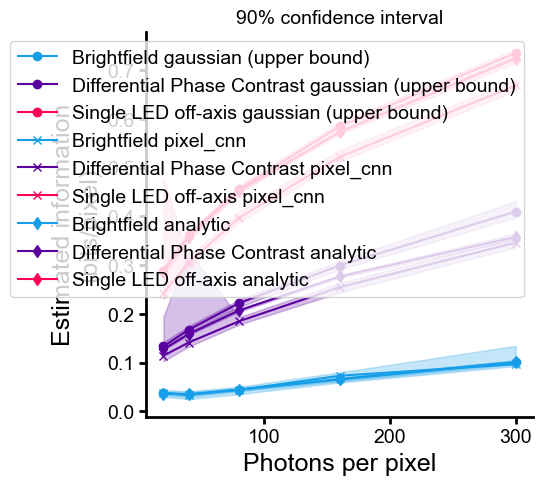

In [3]:
from cleanplots import *

colors =  get_color_cycle()
markers = ['o', 'x', 'd']
models = ['gaussian (upper bound)', 'pixel_cnn', 'analytic']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, (means, confidences) in enumerate(zip([mi_means_by_channel_photons, mi_means_by_channel_photons_pixel_cnn, mi_means_by_channel_photons_analytic], 
                              [mi_confidences_by_channel_photons, mi_confidences_by_channel_photons_pixel_cnn, mi_confidences_by_channel_photons_analytic])):
    for channel, color in zip(channel_names, colors):
        ax.plot(photons_per_pixel, means[channel], label=get_display_channel_names(channel) + ' ' + models[i],
                color=color, linestyle='-', marker=markers[i])
        ax.fill_between(photons_per_pixel, confidences[channel][:, 0], confidences[channel][:, 1], alpha=0.25, color=color)

ax.set(xlabel='Photons per pixel', ylabel='Estimated information\n(bits/pixel)')
ax.legend()
clear_spines(ax)
ax.title.set_text(f'{confidence_interval}% confidence interval')

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/analytic_vs_nll_entropy.pdf', transparent=True)